#  Understanding and Predicting Property Maintenance Fines in Detroit:

With the feature investigation done with, its time to try out some models, and evaluate them.

In [1]:
#Imports and Settings:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

#Settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)
%matplotlib inline 
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 40)
pd.set_option('display.width', 1000)

### Support Functions:

In [2]:
#Lets set up our input and target data
#Lets add a difference column
def getdiffindays(hdate, tdate):
    return ((hdate - tdate).total_seconds())/86400

def getfeatures():
    from sklearn.model_selection import train_test_split
    
    xyTrain = pd.read_csv("./readonly/train.csv",encoding = "ISO-8859-1")

    #this came from our isnull() summing; some columns are basically all NA. Useless for us, and I have no data join to correct.
    for col in ["violation_zip_code", "non_us_str_code", "payment_date", "collection_status", "grafitti_status"]:
        xyTrain.drop(columns=[col], axis=1,inplace=True)

    xyTrain.dropna(inplace=True)
    xyTrain = xyTrain.reset_index(drop=True)

    xyTrain["agency_name"] = xyTrain["agency_name"].astype("category")
    xyTrain["agency_codes"] = xyTrain["agency_name"].cat.codes
    xyTrain["disposition"] = xyTrain["disposition"].astype("category")
    xyTrain["disposition_codes"] = xyTrain["disposition"].cat.codes
    xyTrain["violation_code"] = xyTrain["violation_code"].astype("category")
    xyTrain["violation_code_levels"] = xyTrain["violation_code"].cat.codes

    xyTrain["hearing_date"] = pd.to_datetime(arg=xyTrain["hearing_date"], format="%Y-%m-%d %H:%M:%S")
    xyTrain["ticket_issued_date"] = pd.to_datetime(arg=xyTrain["ticket_issued_date"], format="%Y-%m-%d %H:%M:%S")

    xyTrain.astype({"compliance":"int"},inplace=True) #doesn't need to be a float.


    #Clever solution from: https://stackoverflow.com/questions/13331698/...
    #...how-to-apply-a-function-to-two-columns-of-pandas-dataframe
    xyTrain['time_diff'] = xyTrain[['hearing_date','ticket_issued_date']].apply(lambda x: getdiffindays(*x), axis=1)

    #filter out negative times from our dataframe
    xyTrain = xyTrain[xyTrain["time_diff"] > 0]

    #first, split off 10% of xyTrain to get some test data. Set a random seed.
    (xy_Train, xy_Test) = train_test_split(xyTrain,test_size=0.1,random_state=0)
    
    
    y_Train = xy_Train["compliance"]
    x_Train = xy_Train.drop(columns=["compliance","compliance_detail"],axis=1)
    y_Test = xy_Test["compliance"]
    x_Test = xy_Test.drop(columns=["compliance","compliance_detail"],axis=1)
    
    return (x_Train,y_Train,x_Test,y_Test)

## Model Submitted for the Assignment:

The model below achieved an AUC score of 0.765, and cross-validation accuracy of > 0.93 The following was noted before building the model:

1) There are no targets for our test set - we are simply to produce a prediction and then return it with the blight_model() function. The targets of the test set are to be withheld, and used by the auto_grader. 

2) The test set has a restricted set of features. This is done to reduce the risk of **Data Leakage**. 

3) Because our test set has no targets, we have to create a validation set with our training data - which is thankfully quite large (90MB in size). We might as well do Cross Validation, because we can.

4) Our evaluation metric is area under curve. Since this involves a ROC curve graph, we will inevitalbly have to vary parameters.

5) Considering (3) and (4), it makes sense to use GridSearchCV. for our question. It will do CV across a parameter space for us, automatically.

6) Given what was taught in lecture, it makes sense to try first with **Random Forest** and **Gradient Boosted Decision Trees**. We can just throw in features (unnormalized), with gridSearch.

### Default Features:

Without doing any feature analysis, and only restricting ourselves to features the test.csv file has, I will use the folloiwng features, as they require minimal processing. 

- late_fee-(possible bad sign - they can't pay or don't want to).
- discount_amount:(if allotted - might indicate negotiation or leeway)
- judgment_amount:(outstanding sum of payments)


In [3]:
#Call this so all the algorithms after this point have data.
(x_Train,y_Train,x_Test,y_Test) = getfeatures()

/home/sean/DSDEenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [17]:
#Assumes getfeatures has been called, and placed test/train partition into global scope
def bm_minimal_acc():
    #sort out train x for predict
    x_TrainSubset = x_Train.loc[:,["late_fee","discount_amount","judgment_amount"]]
    x_TestSubset = x_Test.loc[:,["late_fee","discount_amount","judgment_amount"]]
    
    parameters = {"n_estimators":list(range(1,31)), "max_depth":list(range(1,11)),"n_jobs":[8]}         
    blightRF = GridSearchCV(RandomForestClassifier(),param_grid=parameters,scoring="accuracy")
    blightRF.fit(x_TrainSubset, y_Train)

    print('Grid best parameter (max. acc): ', blightRF.best_params_)
    print('Grid best score (accuracy): ', blightRF.best_score_)    
    
    print("Separate Test Set Accuracy: ", accuracy_score(y_Test,blightRF.predict(x_TestSubset)))
    return None
    
def bm_minimal_auc():
    (x_Train,y_Train,x_Test,y_Test) = getfeatures()

    #sort out train x for predict
    x_TrainSubset = x_Train.loc[:,["late_fee","discount_amount","judgment_amount"]]
    x_TestSubset = x_Test.loc[:,["late_fee","discount_amount","judgment_amount"]]

    parameters = {"n_estimators":list(range(1,31)), "max_depth":list(range(1,11)),"n_jobs":[8]}         
    blightRF = GridSearchCV(RandomForestClassifier(),param_grid=parameters,scoring="roc_auc")
    blightRF.fit(x_TrainSubset, y_Train)

    print('Grid best parameter (max. acc): ', blightRF.best_params_)
    print('Grid best score (accuracy): ', blightRF.best_score_)    

    print("Separate Test Set AUC: ", roc_auc_score(y_Test,blightRF.predict(x_TestSubset)))
    return None

bm_minimal_acc()
          
bm_minimal_auc()



/home/sean/DSDEenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/sean/DSDEenv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Grid best parameter (max. acc):  {'max_depth': 3, 'n_estimators': 6, 'n_jobs': 8}
Grid best score (accuracy):  0.9354297367340292
Separate Test Set Accuracy:  0.9346800917665052


/home/sean/DSDEenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/sean/DSDEenv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Grid best parameter (max. acc):  {'max_depth': 6, 'n_estimators': 23, 'n_jobs': 8}
Grid best score (accuracy):  0.7548509940029904
Separate Test Set AUC:  0.550489054269121


We can see that Accuracy is a lot higher than AUC, which is a measure of area under an ROC curve (y axis - TPR, x-axis FPR). What does our confusion matrix look like? Did AUC models overfit?


In [24]:
x_TrainSubset = x_Train.loc[:,["late_fee","discount_amount","judgment_amount"]]
x_TestSubset = x_Test.loc[:,["late_fee","discount_amount","judgment_amount"]]

#parameters 1: max_depth 3, n_estimators, 6
blightRF1 = RandomForestClassifier(max_depth=3,n_estimators=6).fit(x_TrainSubset, y_Train)
b1cm_train = confusion_matrix(y_Train, blightRF1.predict(x_TrainSubset))
b1cm_test = confusion_matrix(y_Test, blightRF1.predict(x_TestSubset))
print("Model 1:")
print("Training Set Confusion Matrix: \n", b1cm_train)
print("Test Set Confusion Matrix: \n", b1cm_test)
                             
                             
#parameters 2: max_depth 6, n_estimators 23
blightRF2 = RandomForestClassifier(max_depth=6,n_estimators=23).fit(x_TrainSubset, y_Train)
b2cm_train = confusion_matrix(y_Train, blightRF2.predict(x_TrainSubset))
b2cm_test = confusion_matrix(y_Test, blightRF2.predict(x_TestSubset))
print("\n Model 2:")
print("Training Set Confusion Matrix:\n", b2cm_train)
print("Test Set Confusion Matrix:\n", b2cm_test)                             

Model 1:
Training Set Confusion Matrix: 
 [[131052     52]
 [  9067   1055]]
Test Set Confusion Matrix: 
 [[14552     5]
 [ 1020   115]]
Model 2:
Training Set Confusion Matrix:
 [[131052     52]
 [  9067   1055]]
Test Set Confusion Matrix:
 [[14552     5]
 [ 1020   115]]


Strangely, **the matrix elements are the same for both models!** I am not repeating parameters or making a mistake!

Practically, we want to predict who will not pay their tickets. Suppose we send officers/collection agents after people 
to increase compliance. Is it more preferable to have a high False Positive, or False Negative? For Revenue, the former,
but for fairness to citizens, the latter. The latter has been optimized, it seems.

### Trying a RF with our new features:

I just use all the features to see what happens. Code for models is similar to what is above.


In [31]:
x_Test.isnull().count()

ticket_id                     15692
agency_name                   15692
inspector_name                15692
violator_name                 15692
violation_street_number       15692
violation_street_name         15692
mailing_address_str_number    15692
mailing_address_str_name      15692
city                          15692
state                         15692
zip_code                      15692
country                       15692
ticket_issued_date            15692
hearing_date                  15692
violation_code                15692
violation_description         15692
disposition                   15692
fine_amount                   15692
admin_fee                     15692
state_fee                     15692
late_fee                      15692
discount_amount               15692
clean_up_cost                 15692
judgment_amount               15692
payment_amount                15692
balance_due                   15692
payment_status                15692
agency_codes                

In [32]:
featureList = ["late_fee","discount_amount","judgment_amount","violation_code_levels","disposition_codes","agency_codes","time_diff"]

def bm_full_acc():
    #sort out train x for predict
    x_TrainSubset = x_Train.loc[:,featureList]
    x_TestSubset = x_Test.loc[:,featureList]
    
    parameters = {"n_estimators":list(range(1,31)), "max_depth":list(range(1,11)),"n_jobs":[8]}         
    blightRF = GridSearchCV(RandomForestClassifier(),param_grid=parameters,scoring="accuracy")
    blightRF.fit(x_TrainSubset, y_Train)

    print('Grid best parameter (max. acc): ', blightRF.best_params_)
    print('Grid best score (accuracy): ', blightRF.best_score_)    
    
    print("Separate Test Set Accuracy: ", accuracy_score(y_Test,blightRF.predict(x_TestSubset)))
    return None
    
def bm_full_auc():
    #sort out train x for predict
    x_TrainSubset = x_Train.loc[:,featureList]
    x_TestSubset = x_Test.loc[:,featureList]

    parameters = {"n_estimators":list(range(1,31)), "max_depth":list(range(1,11)),"n_jobs":[8]}         
    blightRF = GridSearchCV(RandomForestClassifier(),param_grid=parameters,scoring="roc_auc")
    blightRF.fit(x_TrainSubset, y_Train)

    print('Grid best parameter (max. acc): ', blightRF.best_params_)
    print('Grid best score (accuracy): ', blightRF.best_score_)    

    print("Separate Test Set AUC: ", roc_auc_score(y_Test,blightRF.predict(x_TestSubset)))
    return None

bm_full_acc()

bm_full_auc()

/home/sean/DSDEenv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Grid best parameter (max. acc):  {'max_depth': 10, 'n_estimators': 13, 'n_jobs': 8}
Grid best score (accuracy):  0.9440825343775225
Separate Test Set Accuracy:  0.9434106551108845


/home/sean/DSDEenv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Grid best parameter (max. acc):  {'max_depth': 10, 'n_estimators': 29, 'n_jobs': 8}
Grid best score (accuracy):  0.8130270822907559
Separate Test Set AUC:  0.6230269041129219


Our accuracy score increased by no more than 0.01. Our AUC score has increased significantly. Lets take a look: at our confusion matrices. 

In [33]:
x_TrainSubset = x_Train.loc[:,featureList]
x_TestSubset = x_Test.loc[:,featureList]

#parameters 1: max_depth 3, n_estimators, 6
blightRF1 = RandomForestClassifier(max_depth=10,n_estimators=13).fit(x_TrainSubset, y_Train)
b1cm_train = confusion_matrix(y_Train, blightRF1.predict(x_TrainSubset))
b1cm_test = confusion_matrix(y_Test, blightRF1.predict(x_TestSubset))
print("Model 1:")
print("Training Set Confusion Matrix: \n", b1cm_train)
print("Test Set Confusion Matrix: \n", b1cm_test)
                             
                             
#parameters 2: max_depth 6, n_estimators 23
blightRF2 = RandomForestClassifier(max_depth=10,n_estimators=29).fit(x_TrainSubset, y_Train)
b2cm_train = confusion_matrix(y_Train, blightRF2.predict(x_TrainSubset))
b2cm_test = confusion_matrix(y_Test, blightRF2.predict(x_TestSubset))
print("\n Model 2:")
print("Training Set Confusion Matrix:\n", b2cm_train)
print("Test Set Confusion Matrix:\n", b2cm_test)                             

Model 1:
Training Set Confusion Matrix: 
 [[130881    223]
 [  7627   2495]]
Test Set Confusion Matrix: 
 [[14525    32]
 [  854   281]]

 Model 2:
Training Set Confusion Matrix:
 [[130869    235]
 [  7587   2535]]
Test Set Confusion Matrix:
 [[14524    33]
 [  854   281]]


Finally, I try out the SHAP library to get the significance of all the features I have tried:

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=13,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

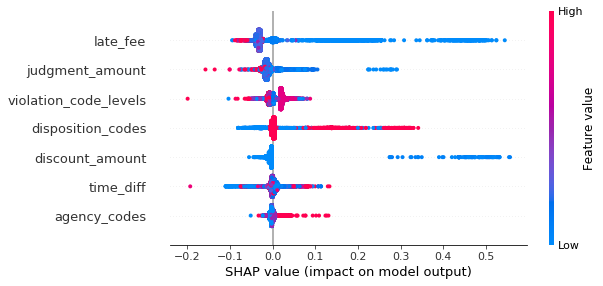

In [4]:
import shap 

featureList = ["late_fee","discount_amount","judgment_amount","violation_code_levels","disposition_codes","agency_codes","time_diff"]

x_TrainSubset = x_Train.loc[:,featureList]
x_TestSubset = x_Test.loc[:,featureList]


#Final Model 1:
rf = RandomForestClassifier(n_estimators=13, max_depth=10)
rf.fit(x_TrainSubset, y_Train)

exp = shap.TreeExplainer(rf, x_TrainSubset)
shap_values = exp.shap_values(x_TestSubset)

shap.summary_plot(shap_values[1], x_TestSubset)



This diagram confirms what other students found in the course: *late_fee, judgement_amount, and discount_amount* all had 
the biggest impact on model performance. Other features contributed less. 

Because of the sensetivity of RFs to bootstraping of data and metric, I won't pursue this further.

**My Conclusion:** Trying out my other features of interest had minimal impact on accuracy. This was confirmed by seeing discussions about what other students tried, on the Course Web Forums.

I can't draw any conclusions for AUC, as it varys significantly from the course scoring algorithm, and on the subset of data that is provided to calculate it.

**END**